The goal of this project is to create a Bot that can idenify clients that may pull their money out from our banking service.

In [38]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

df = pd.read_csv(r'C:\Users\Justin\Downloads\data\TT projects\8\raw data.csv')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [40]:
df.isnull().any().any()

True

In [41]:
df['Tenure'].isnull().sum()

909

Only null values are in the Tenure column.

In [42]:
median_tenure = df['Tenure'].median()
print(median_tenure)

5.0


In [43]:
df['Tenure'].fillna(median_tenure, inplace=True)

C:\Users\Justin\AppData\Local\Temp\ipykernel_247940\3630085065.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tenure'].fillna(median_tenure, inplace=True)


In [44]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [45]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [46]:
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Data that is not needed for our analysis is: RowNumber, CustomerId, and Surname.

In [47]:
df['Age'].min()

18

In [48]:
df['Age'].max()

92

In [49]:
df_age = df['Age']

In [ ]:

age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49',
              '50-59', '60-69', '70-79', '80-89', '90-99']

df_age_decade = pd.cut(df['Age'], bins=age_bins,
                       labels=age_labels, right=False)

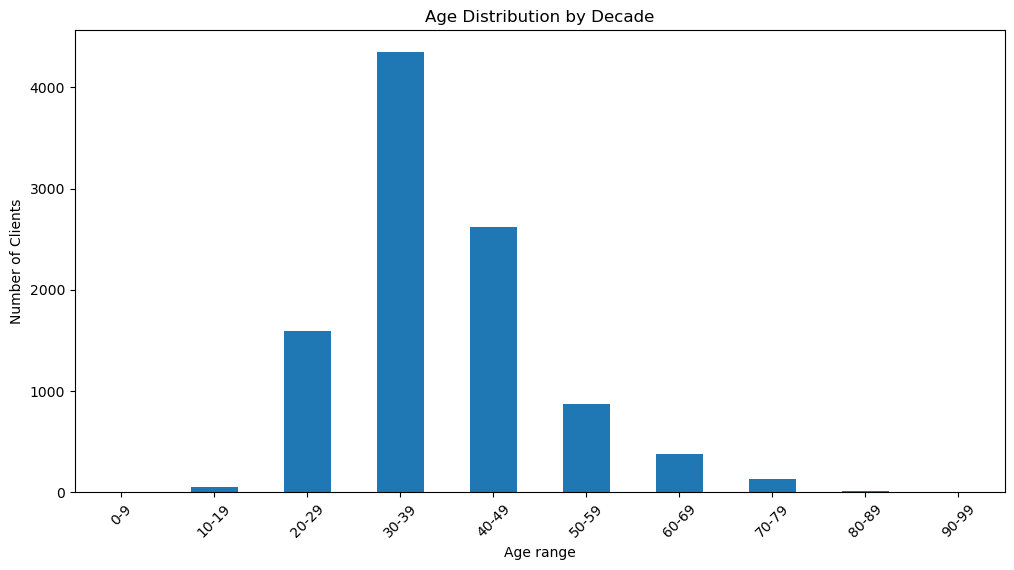

In [ ]:

plt.figure(figsize=(12, 6))
df_age_decade.value_counts().sort_index().plot(kind='bar')
plt.title('Age Distribution by Decade')
plt.xlabel('Age range')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45)
plt.show()

Ages squew toward younger working age poeple in their 30s.

In [52]:
df['EstimatedSalary'].min()

11.58

In [53]:
df['EstimatedSalary'].max()

199992.48

In [54]:
df_salary = df['EstimatedSalary']

In [ ]:
sal_bins = [0, 20000, 40000, 60000, 80000, 100000,
            120000, 140000, 160000, 180000, 200000]
sal_labels = ['0-19999', '20000-39999', '40000-59999', '60000-79999', '80000-99999',
              '100000-119999', '120000-139999', '140000-159999', '160000-179999', '180000-199999']

df_sal_bracket = pd.cut(df['EstimatedSalary'],
                        bins=sal_bins, labels=sal_labels, right=False)

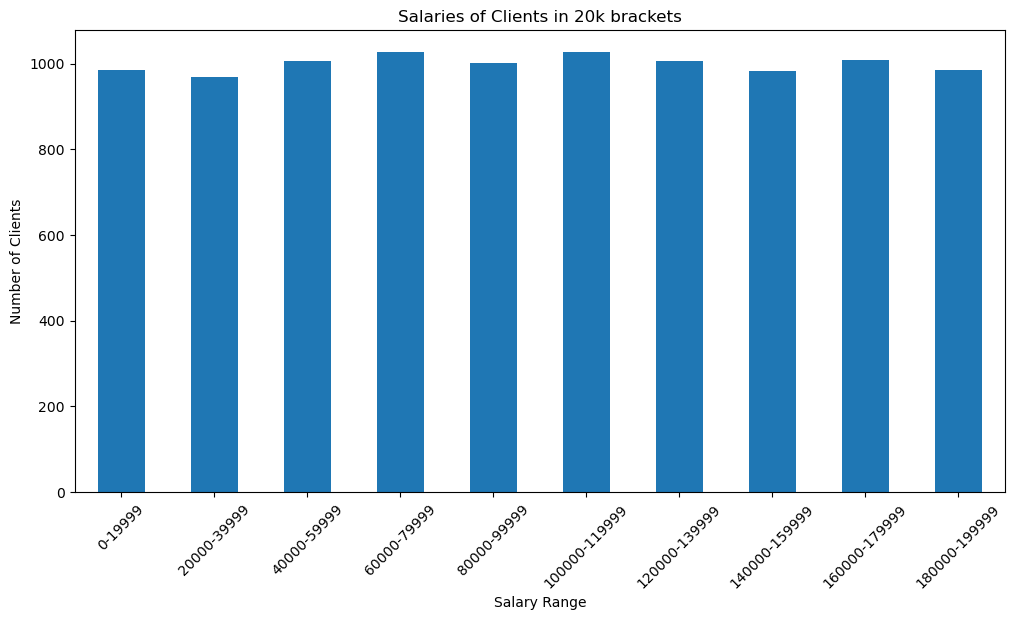

In [56]:
plt.figure(figsize=(12, 6))
df_sal_bracket.value_counts().sort_index().plot(kind='bar')
plt.title('Salaries of Clients in 20k brackets')
plt.xlabel('Salary Range')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45)
plt.show()

Salaries look to be almost evenly distributed.

Gender and Geography need to be encoded.

In [57]:
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False


In [58]:
duplicate_count_ohe = data_ohe.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count_ohe}")

Number of duplicate rows: 0


In [ ]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

In [60]:
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [61]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=12345)

In [ ]:

model_lr_imb = LogisticRegression(random_state=54321, solver="liblinear")
model_lr_imb.fit(features_train, target_train)
score_train_imb = model_lr_imb.score(features_train, target_train)

print("Accuracy of the logistic regression imbalanced model on the training set:", score_train_imb,)

Accuracy of the logistic regression imbalanced model on the training set: 0.7913333333333333


In [63]:
for depth in range(1, 10):
    model_dt_imb = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt_imb.fit(features_train, target_train)
    predictions_valid_imb = model_dt_imb.predict(features_valid)
    print('max_depth =', depth, ': ', end='')
    print(accuracy_score(target_valid, predictions_valid_imb))

max_depth = 1 : 0.8045
max_depth = 2 : 0.8325
max_depth = 3 : 0.843
max_depth = 4 : 0.849
max_depth = 5 : 0.8545
max_depth = 6 : 0.8595
max_depth = 7 : 0.86
max_depth = 8 : 0.85
max_depth = 9 : 0.843


In [ ]:
best_score = 0
best_est = 0
for est in range(1, 5):
    modelRF = RandomForestClassifier(random_state=54321, n_estimators=est)
    modelRF.fit(features_train, target_train)
    score = modelRF.score(features_train, target_train)
    if score > best_score:
        best_score = score
        best_est = est

print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(
    best_est, best_score))

Accuracy of the best model on the validation set (n_estimators = 3): 0.9611666666666666


In [65]:

final_model = RandomForestClassifier(random_state=54321)
final_model.fit(features_train, target_train)
test_predictions = final_model.predict(features_valid)

print('Test set Random Forest:', accuracy_score(target_valid, test_predictions))
print('F1:', f1_score(target_valid, test_predictions))

Test set Random Forest: 0.862
F1: 0.5576923076923077


In [66]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

model_up = LogisticRegression(random_state=12345, solver='liblinear')
model_up.fit(features_upsampled, target_upsampled)
predicted_valid = model_up.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.352561144439317


In [67]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

model_down = LogisticRegression(random_state=12345, solver='liblinear')
model_down.fit(features_downsampled, target_downsampled)
predicted_valid = model_down.predict(features_valid)

print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.3417890520694259


Upscaling looks to be the better choice here.

In [ ]:

model_up = LogisticRegression(random_state=12345, solver='liblinear')
model_up.fit(features_upsampled, target_upsampled)
test_predictions = model_up.predict(features_valid)
print('F1:', f1_score(target_valid, test_predictions))

F1: 0.352561144439317


In [69]:
model_up = LogisticRegression(random_state=12345, solver='liblinear')
model_up.fit(features_upsampled, target_upsampled)
test_predictions = model_up.predict(features_test)
print('F1:', f1_score(target_test, test_predictions))

F1: 0.3809090909090909


In [70]:
final_model = RandomForestClassifier(random_state=54321)
final_model.fit(features_upsampled, target_upsampled)
test_predictions = final_model.predict(features_valid)

print('F1:', f1_score(target_valid, test_predictions))

F1: 0.5702127659574469


In [71]:
final_model = RandomForestClassifier(random_state=54321)
final_model.fit(features_upsampled, target_upsampled)
test_predictions = final_model.predict(features_test)

print('F1:', f1_score(target_test, test_predictions))

F1: 0.5965834428383706


In [72]:

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.6813607600469863
